In [1]:
import os
import sys 

import matplotlib.pyplot as plt
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from data_generator import *
from model import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
print(tf.__version__)

2022-11-29 19:12:54.925238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 19:12:55.065888: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 19:12:55.702274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib

2.11.0


In [2]:
sys.path.append("../")
from metrics import *

In [3]:
TRAIN_PATH = 'data/train/'
VAL_PATH = 'data/test/'

MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [4]:
image_generator = ImageDataGenerator(
    rotation_range=12,
    rescale=1./255,
    shear_range=.1,
    zoom_range=.15,
    brightness_range=[.85, 1.0],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    rotation_range=12,
    shear_range=.1,
    zoom_range=.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

In [5]:
train_generator = generator(
    TRAIN_PATH,
    image_generator,
    label_generator, 
    batch_sz=12
)
val_generator = generator(
    VAL_PATH,
    image_generator,
    label_generator, 
    batch_sz=8
)

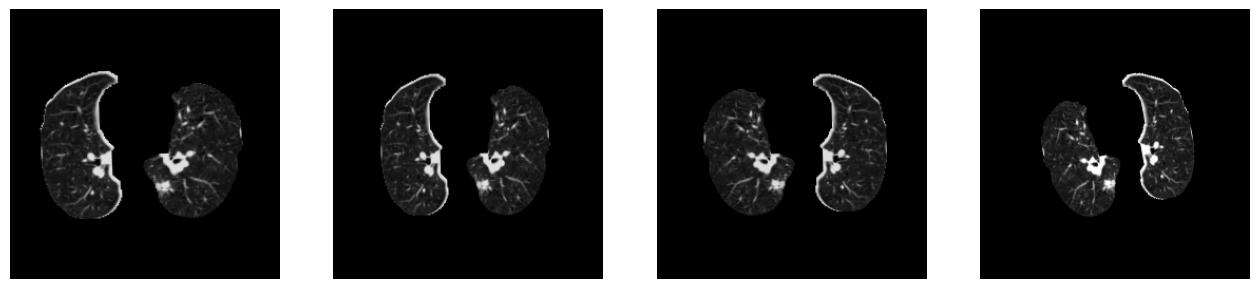

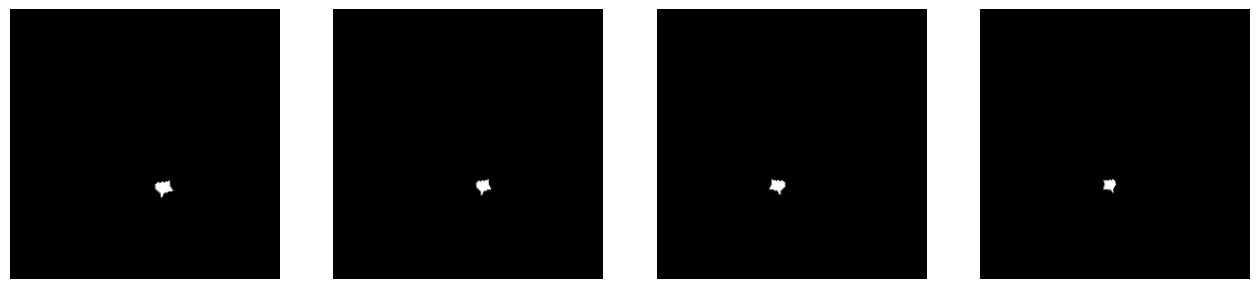

In [6]:
show_augmentation('data/train/image/735.tif', image_generator, n_rows=1)
show_augmentation('data/train/label/735.tif', label_generator, n_rows=1)

## Instantiate the U-Net

In [7]:
model = unet_2d_res()
model.compile(
    optimizer = Adam(lr = 1e-4),
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=0, save_best_only=True)

2022-11-29 19:12:57.433694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:12:57.472292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:12:57.474202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:12:57.476491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  131584      ['add_2[0][0]']                  
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

 concatenate_2 (Concatenate)    (None, 128, 128, 38  0           ['up_sampling2d_2[0][0]',        
                                4)                                'add_1[0][0]']                  
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 38  1536       ['concatenate_2[0][0]']          
 ormalization)                  4)                                                                
                                                                                                  
 activation_12 (Activation)     (None, 128, 128, 38  0           ['batch_normalization_18[0][0]'] 
                                4)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 12  442496      ['activation_12[0][0]']          
          

## Train the U-Net

In [9]:
model_history = model.fit_generator(
    train_generator,
    validation_data= val_generator,
    validation_steps=500//8,
    steps_per_epoch=1000,
    epochs = 20,
    callbacks=[model_checkpoint]
)
# model_history = model.fit_generator(
#     train_generator,
#     validation_data= val_generator,
#     validation_steps=500//8,
#     steps_per_epoch=500,
#     epochs = 10,
#     callbacks=[model_checkpoint]
# )

Found 4043 images belonging to 1 classes.


/tmp/ipykernel_10210/3100437093.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Found 4043 images belonging to 1 classes.
Epoch 1/20
Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32)
Tensor("model/multiply/mul:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32)
Tensor("model/multiply/mul:0", shape=(None, 256, 256, 1), dtype=float32)


2022-11-29 19:13:06.398508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2022-11-29 19:13:12.668115: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd40b2bcd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-29 19:13:12.668146: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-11-29 19:13:12.673112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-29 19:13:12.786154: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-11-29 19:13:13.265007: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.44GiB with freed_by_count=0. The caller indicat

  22/1000 [..............................] - ETA: 13:28 - loss: nan - accuracy: 0.9921 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00

KeyboardInterrupt: 

## Save Trained Model 

In [ ]:
model.save('unet_lidc.hdf5') 

In [ ]:
model.load_weights('unet_lidc.hdf5') 
# model.load_weights('../../trained_segmentation_models/unet_lidc_curbest.hdf5')

## Inspect Results

**Training example prediction**

In [ ]:
train_idx = np.random.randint(len(os.listdir('data/train/image')))
print(train_idx)

img0 = imread(f'data/train/image/{train_idx}.tif', as_gray=True)/255
mask0 = imread(f'data/train/label/{train_idx}.tif', as_gray=True)
x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256)), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")


plt.show()

**Test example prediction**

In [ ]:
test_idx = np.random.randint(len(os.listdir('data/test/image')))
# test_idx = 53
img0 = imread(f'data/test/image/{test_idx}.tif', as_gray=True)/255
mask0 = imread(f'data/test/label/{test_idx}.tif', as_gray=True)

x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256)), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()